 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn

from src.da_models.adda import ADDAST
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights


# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_1580647/3989290663.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn(
        'Using CPU', 
        stacklevel=2)

cuda:3


In [3]:
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 1024
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

PROCESSED_DATA_DIR = "data/preprocessed"

MODEL_NAME = "ADDA"


In [4]:
## Adversarial Hyperparameters

EPOCHS = 200
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS
ENC_LR = 0.0002
ADAM_BETA_1 = 0.5
ALPHA = 2
DIS_LOOP_FACTOR = 5

In [5]:
model_folder = os.path.join("model", MODEL_NAME, script_start_time)

model_folder = os.path.join("model", MODEL_NAME, "V2")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

# if not os.path.isdir(results_folder):
#     os.makedirs(results_folder)


In [6]:
# # sc.logging.print_versions()
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
# sc.settings.verbosity = 3


 # Data load

In [7]:
# Load spatial data
mat_sp_test_s_d = {}
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_test_s_d.hdf5"), "r") as f:
    for sample_id in f:
        mat_sp_test_s_d[sample_id] = f[sample_id][()]

if TRAIN_USING_ALL_ST_SAMPLES:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
        mat_sp_train_s = f["all"][()]
else:
    mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
    sc_mix_train_s = f["X/train"][()]
    sc_mix_val_s = f["X/val"][()]
    sc_mix_test_s = f["X/test"][()]

    lab_mix_train = f["y/train"][()]
    lab_mix_val = f["y/val"][()]
    lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [8]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train_s)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )
    target_train_set_dis = SpotDataset(deepcopy(mat_sp_train_s))
    dataloader_target_train_dis = torch.utils.data.DataLoader(
        target_train_set_dis,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(deepcopy(mat_sp_test_s_d[sample_id]))
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(deepcopy(mat_sp_test_s_d[sample_id]))
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )


 ## Define Model

In [9]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1], is_adda=True)
model.apply(initialize_weights)
model.to(device)


ADDAST(
  (source_encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
    )
  )
  (clf): AddaPredictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
    )
  )
)

 ## Pretrain

In [10]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [11]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [12]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [13]:
model.pretraining()


In [14]:
"""
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

checkpoint = {
    "epoch": -1,
    "model": model,
    "optimizer": pre_optimizer,
    "scheduler": pre_scheduler,
    # 'scaler': scaler
}
for epoch in range(INITIAL_TRAIN_EPOCHS):
    checkpoint["epoch"] = epoch

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, batch in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        pre_scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))
    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),
        # "next_lr:", scheduler.get_last_lr(),
        end=" ",
    )
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

        print("<-- new best val loss")
    else:
        print("")

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
        print(f"Validation loss plateaued after {early_stop_count} at epoch {epoch}")
        torch.save(checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth"))
        break

    early_stop_count += 1


# Save final model
best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))
"""


'\n# Initialize lists to store loss and accuracy values\nloss_history = []\nloss_history_val = []\n\nloss_history_running = []\n\n# Early Stopping\nbest_loss_val = np.inf\nearly_stop_count = 0\n\n\n# Train\nprint("Start pretrain...")\nouter = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)\ninner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)\n\ncheckpoint = {\n    "epoch": -1,\n    "model": model,\n    "optimizer": pre_optimizer,\n    "scheduler": pre_scheduler,\n    # \'scaler\': scaler\n}\nfor epoch in range(INITIAL_TRAIN_EPOCHS):\n    checkpoint["epoch"] = epoch\n\n    # Train mode\n    model.train()\n    loss_running = []\n    mean_weights = []\n\n    inner.refresh()  # force print final state\n    inner.reset()  # reuse bar\n    for _, batch in enumerate(dataloader_source_train):\n        # lr_history_running.append(scheduler.get_last_lr())\n\n        pre_optimizer.zero_grad()\n        loss = model_loss(*batch, model)\n        loss_running.appen

 ## Adversarial Adaptation

In [15]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [16]:
def cycle_iter(iter):
    while True:
        yield from iter


def iter_skip(iter, n=1):
    for i in range(len(iter)*n):
        if (i % n) == n - 1:
            yield next(iter)
        else:
            yield None, None


In [17]:
criterion_dis = nn.BCEWithLogitsLoss()


In [18]:
def discrim_loss_accu(x, domain, model):
    x = x.to(device)

    if domain == 'source':
        y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.source_encoder(x) #.view(x.shape[0], -1)
    elif domain == 'target':
        y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.target_encoder(x) #.view(x.shape[0], -1)
    else:
        raise(ValueError, f"invalid domain {domain} given, must be 'source' or 'target'")

    y_pred = model.dis(emb)

    loss = criterion_dis(y_pred, y_dis)
    accu = torch.mean(
        (torch.round(y_pred).to(torch.long) == y_dis).to(torch.float32)
    ).cpu()

    return loss, accu


# def discrim_loss_accu(x_source, x_target, model):
#     # x = x.to(device)

#     x_source, x_target = x_source.to(device), x_target.to(device)

#     # if domain == 'source':
#     #     y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.source_encoder(x) #.view(x.shape[0], -1)
#     # elif domain == 'target':
#     #     y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.target_encoder(x) #.view(x.shape[0], -1)
#     # else:
#     #     raise(ValueError, f"invalid domain {domain} given, must be 'source' or 'target'")

#     y_dis = torch.cat(
#         [
#             torch.zeros(x_source.shape[0], device=device, dtype=x_source.dtype).view(
#                 -1, 1
#             ),
#             torch.ones(x_target.shape[0], device=device, dtype=x_target.dtype).view(
#                 -1, 1
#             ),
#         ]
#     )
#     x = torch.cat([x_source, x_target])
#     emb = model.source_encoder(x)  # .view(x.shape[0], -1)
#     y_pred = model.dis(emb)

#     loss = criterion_dis(y_pred, y_dis)
#     accu = torch.mean(
#         (torch.round(y_pred).to(torch.long) == y_dis).to(torch.float32)
#     ).cpu()

#     return loss, accu


def compute_acc_dis(dataloader_source, dataloader_target, model):
    loss_history = []
    accu_history = []
    # iters = max(len(dataloader_source), len(dataloader_target))
    model.eval()
    model.dis.eval()
    model.target_encoder.eval()
    model.source_encoder.eval()
    with torch.no_grad():
        loss_running = []
        accu_running = []
        mean_weights = []
        # batch_cycler = zip(cycle_iter(dataloader_source), cycle_iter(dataloader_target))
        for _, (X, _) in enumerate(dataloader_source):
            X = X.to(device)

            y_dis = torch.zeros(X.shape[0], device=device, dtype=X.dtype).view(-1, 1)

            emb = model.source_encoder(X)  # .view(X.shape[0], -1)

            y_pred = model.dis(emb)

            loss_running.append(criterion_dis(y_pred, y_dis).item())
            accu_running.append(
                torch.mean(
                    (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(
                        torch.float32
                    )
                ).cpu()
            )
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

        loss_running = []
        accu_running = []
        mean_weights = []
        for _, (X, _) in enumerate(dataloader_target):
            X = X.to(device)

            y_dis = torch.ones(X.shape[0], device=device, dtype=X.dtype).view(-1, 1)

            emb = model.source_encoder(X)  # .view(X.shape[0], -1)

            y_pred = model.dis(emb)

            loss_running.append(criterion_dis(y_pred, y_dis).item())
            accu_running.append(
                torch.mean(
                    (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(
                        torch.float32
                    )
                ).cpu()
            )
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

    return np.average(loss_history), np.average(accu_history)


def encoder_loss(x_target, model):
    x_target = x_target.to(device)

    # flip label
    y_dis = torch.zeros(x_target.shape[0], device=device, dtype=x_target.dtype).view(
        -1, 1
    )

    emb_target = model.target_encoder(x_target)  # .view(x_target.shape[0], -1)
    y_pred = model.dis(emb_target)
    loss = criterion_dis(y_pred, y_dis)

    return loss


In [19]:
# def train_adversarial(
#     model,
#     save_folder,
#     dataloader_source_train,
#     dataloader_source_val,
#     dataloader_target_train,
# ):
#     model.to(device)
#     model.advtraining()

#     target_optimizer = torch.optim.Adam(
#         model.target_encoder.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-07
#     )
#     dis_optimizer = torch.optim.Adam(
#         model.dis.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-07
#     )

#     iters = max(len(dataloader_source_train), len(dataloader_target_train))

#     dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
#     )
#     target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
#     )

#     n_samples_source = len(dataloader_source_train.dataset)
#     n_samples_target = len(dataloader_target_train.dataset)
#     p = n_samples_source / (n_samples_source + n_samples_target)
#     rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)

#     # Initialize lists to store loss and accuracy values
#     loss_history = []
#     accu_history = []
#     loss_history_running = []

#     # Early Stopping
#     best_loss_val = np.inf
#     early_stop_count = 0

#     # Train
#     print("Start adversarial training...")
#     print("Discriminator target loss:", rand_loss)
#     outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
#     inner1 = tqdm(total=iters, desc=f"Batch (Discriminator)", position=1)
#     inner2 = tqdm(total=iters, desc=f"Batch (Encoder)", position=2)
#     checkpoint = {
#         "epoch": -1,
#         "model": model,
#         "dis_optimizer": dis_optimizer,
#         "target_optimizer": target_optimizer,
#         "dis_scheduler": dis_scheduler,
#         "target_scheduler": target_scheduler,
#     }
#     for epoch in range(EPOCHS):
#         checkpoint["epoch"] = epoch

#         # Train mode
#         model.train()

#         loss_running = []
#         accu_running = []
#         mean_weights = []

#         inner1.refresh()  # force print final state
#         inner1.reset()  # reuse bar
#         inner2.refresh()  # force print final state
#         inner2.reset()  # reuse bar

#         model.train_discriminator()
#         model.target_encoder.eval()
#         model.source_encoder.eval()
#         model.dis.train()
#         batch_cycler = zip(
#             cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
#         )
#         for _ in range(iters):
#             # lr_history_running.append(scheduler.get_last_lr())
#             dis_optimizer.zero_grad()

#             (x_source, _), (x_target, _) = next(batch_cycler)
#             loss, accu = discrim_loss_accu(x_source, x_target, model)
#             loss_running.append(loss.item())
#             accu_running.append(accu)
#             mean_weights.append(len(x_source) + len(x_target))

#             # scaler.scale(loss).backward()
#             # scaler.step(optimizer)
#             # scaler.update()

#             loss.backward()
#             dis_optimizer.step()
#             dis_scheduler.step()

#             inner1.update(1)

#         loss_history.append(np.average(loss_running, weights=mean_weights))
#         accu_history.append(np.average(accu_running, weights=mean_weights))
#         loss_history_running.append(loss_running)

#         model.train_target_encoder()
#         model.target_encoder.train()
#         model.source_encoder.eval()
#         model.dis.eval()
#         batch_cycler = zip(
#             cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
#         )
#         for _ in range(iters):
#             target_optimizer.zero_grad()

#             _, (x_target, _) = next(batch_cycler)
#             loss = encoder_loss(x_target, model)

#             loss.backward()
#             target_optimizer.step()
#             target_scheduler.step()

#             inner2.update(1)

#         diff_from_rand = math.fabs(loss_history[-1] - rand_loss)

#         # Print the results
#         outer.update(1)
#         print(
#             "epoch:",
#             epoch,
#             "dis loss:",
#             round(loss_history[-1], 6),
#             "dis accu:",
#             round(accu_history[-1], 6),
#             "difference from random loss:",
#             round(diff_from_rand, 6),
#             # "next_lr:", scheduler.get_last_lr(),
#             end=" ",
#         )

#         # Save the best weights
#         if diff_from_rand < best_loss_val:
#             best_loss_val = diff_from_rand
#             torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
#             early_stop_count = 0

#             print("<-- new best difference from random loss")
#         else:
#             print("")

#         # Save checkpoint every 10
#         if epoch % 10 == 0 or epoch >= EPOCHS - 1:
#             torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

#         # check to see if validation loss has plateau'd
#         if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
#             print(
#                 f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
#             )
#             torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
#             break

#         early_stop_count += 1

#     # Save final model
#     torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [20]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
    dataloader_target_train_dis,
):
    model.to(device)
    model.advtraining()

    target_optimizer = torch.optim.Adam(
        model.target_encoder.parameters(), lr=ENC_LR, betas=(ADAM_BETA_1, 0.999), eps=1e-07
    )
    dis_optimizer = torch.optim.Adam(
        model.dis.parameters(), lr=ALPHA * ENC_LR, betas=(ADAM_BETA_1, 0.999), eps=1e-07
    )

    # iters = -(max_len_dataloader // -(1 + DIS_LOOP_FACTOR))  # ceiling divide

    dataloader_lengths = [
        len(dataloader_source_train),
        len(dataloader_target_train),
        len(dataloader_target_train_dis) * DIS_LOOP_FACTOR,
    ]
    max_len_dataloader = np.amax(dataloader_lengths)
    longest = np.argmax(dataloader_lengths)

    iters_val = max(len(dataloader_source_val), len(dataloader_target_train))

    # dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )
    # target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )

    # Initialize lists to store loss and accuracy values
    loss_history = []
    accu_history = []
    loss_history_val = []
    accu_history_val = []
    loss_history_running = []

    loss_history_gen = []
    loss_history_gen_running = []
    mean_weights_gen = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0
    # Train
    print("Start adversarial training...")
    outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
    inner1 = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)
    checkpoint = {
        "epoch": -1,
        "model": model,
        "dis_optimizer": dis_optimizer,
        "target_optimizer": target_optimizer,
        # "dis_scheduler": dis_scheduler,
        # "target_scheduler": target_scheduler,
    }
    for epoch in range(EPOCHS):
        checkpoint["epoch"] = epoch

        # Train mode
        model.train()
        model.target_encoder.train()
        model.source_encoder.eval()
        model.dis.train()

        loss_running = []
        accu_running = []
        mean_weights = []

        loss_running_gen = []
        mean_weights_gen = []

        inner1.refresh()  # force print final state
        inner1.reset()  # reuse bar


        s_train_iter = iter(dataloader_source_train)
        t_train_iter = iter(dataloader_target_train)
        t_train_dis_iter = iter(dataloader_target_train_dis)
        for i in range(max_len_dataloader):
            try:
                x_source, _ = next(s_train_iter)
            except StopIteration:
                s_train_iter = iter(dataloader_source_train)
                x_source, _ = next(s_train_iter)
            try:
                x_target, _ = next(t_train_iter)
            except StopIteration:
                t_train_iter = iter(dataloader_target_train)
                x_target, _ = next(t_train_iter)

            train_encoder_step = (i % DIS_LOOP_FACTOR) == DIS_LOOP_FACTOR - 1
            
            model.train_discriminator()
            # model.target_encoder.train()
            # model.source_encoder.train()
            # model.dis.train()

            set_requires_grad(model.target_encoder, False)
            set_requires_grad(model.source_encoder, False)
            set_requires_grad(model.dis, True)

            # lr_history_running.append(scheduler.get_last_lr())
            dis_optimizer.zero_grad()

            loss, accu = discrim_loss_accu(x_source, 'source', model)
            loss_running.append(loss.item())
            accu_running.append(accu)
            mean_weights.append(len(x_source))

            
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            dis_optimizer.step()

            dis_optimizer.zero_grad()

            loss, accu = discrim_loss_accu(x_target,'target', model)
            loss_running.append(loss.item())
            accu_running.append(accu)
            mean_weights.append(len(x_target))

            
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            dis_optimizer.step()
            # dis_scheduler.step()
                
            # print(i % DIS_LOOP_FACTOR)
            if train_encoder_step:
                try:
                    x_target_enc, _ = next(t_train_dis_iter)
                except StopIteration:
                    t_train_dis_iter = iter(dataloader_target_train_dis)
                    x_target_enc, _ = next(t_train_dis_iter)
                model.train_target_encoder()
                # model.target_encoder.train()
                # model.source_encoder.train()
                # model.dis.train()

                set_requires_grad(model.target_encoder, True)
                set_requires_grad(model.source_encoder, False)
                set_requires_grad(model.dis, False)

                target_optimizer.zero_grad()

                loss = encoder_loss(x_target_enc, model)

                loss_running_gen.append(loss.item())
                mean_weights_gen.append(len(x_target_enc))

                loss.backward()
                target_optimizer.step()
            # target_scheduler.step()

            inner1.update(1)
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))
        loss_history_running.append(loss_running)
        loss_history_gen.append(np.average(loss_running_gen, weights=mean_weights_gen))
        loss_history_gen_running.append(loss_running_gen)
        
        model.eval()
        model.dis.eval()
        model.target_encoder.eval()
        model.source_encoder.eval()

        set_requires_grad(model, True)
        set_requires_grad(model.target_encoder, True)
        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.dis, True)

        # del batch_cycler
        # with torch.no_grad():
        #     curr_loss_val, curr_acc_val = compute_acc_dis(
        #         dataloader_source_val, dataloader_target_train, model
        #     )
        #     loss_history_val.append(curr_loss_val)
        #     accu_history_val.append(curr_loss_val)

        # Print the results
        outer.update(1)
        print(
            "epoch:",
            epoch,
            "gen train loss:",
            round(loss_history_gen[-1], 6),
            "dis train loss:",
            round(loss_history[-1], 6),
            "dis train accu:",
            round(accu_history[-1], 6),
            # "dis val loss:",
            # round(loss_history_val[-1], 6),
            # "dis val accu:",
            # round(accu_history_val[-1], 6),
            # "next_lr:", scheduler.get_last_lr(),
            end=" ",
        )

        # # Save the best weights
        # if diff_from_rand < best_loss_val:
        #     best_loss_val = diff_from_rand
        #     torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
        #     early_stop_count = 0

        #     print("<-- new best difference from random loss")
        # else:
        #     print("")

        print("")

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= EPOCHS - 1:
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

        # check to see if validation loss has plateau'd
        if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
            print(
                f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
            )
            torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
            break

        early_stop_count += 1

    # Save final model
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))

    return loss_history_running, loss_history_gen_running



In [21]:
# st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151509: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.823409 dis train loss: 0.846666 dis train accu: 0.287068 
epoch: 1 gen train loss: 0.844898 dis train loss: 0.823982 dis train accu: 0.307551 
epoch: 2 gen train loss: 0.823213 dis train loss: 0.810362 dis train accu: 0.310486 
epoch: 3 gen train loss: 0.832748 dis train loss: 0.804572 dis train accu: 0.316641 
epoch: 4 gen train loss: 0.833499 dis train loss: 0.80885 dis train accu: 0.312015 
epoch: 5 gen train loss: 0.821583 dis train loss: 0.802228 dis train accu: 0.322226 
epoch: 6 gen train loss: 0.834927 dis train loss: 0.802451 dis train accu: 0.325487 
epoch: 7 gen train loss: 0.817634 dis train loss: 0.79601 dis train accu: 0.326281 
epoch: 8 gen train loss: 0.828915 dis train loss: 0.787751 dis train accu: 0.33103 
epoch: 9 gen train loss: 0.82303 dis train loss: 0.790013 dis train accu: 0.331336 
epoch: 10 gen train loss: 0.815616 dis train loss: 0.779695 dis train accu: 0.334087 
epoch: 11 gen train loss: 0.807133 dis train loss: 0.7786 dis train 

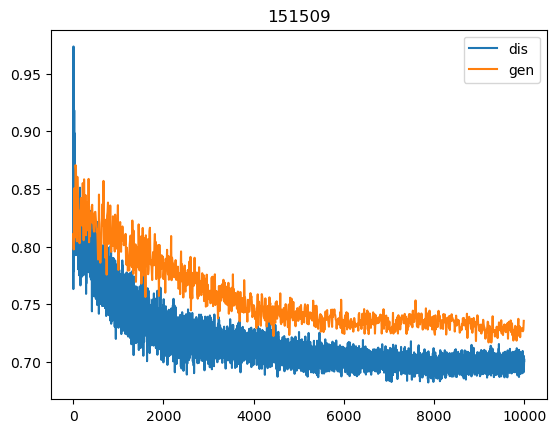

Adversarial training for ST slide 151510: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.93951 dis train loss: 0.861043 dis train accu: 0.299752 
epoch: 1 gen train loss: 0.846233 dis train loss: 0.821825 dis train accu: 0.304204 
epoch: 2 gen train loss: 0.823026 dis train loss: 0.824726 dis train accu: 0.303748 
epoch: 3 gen train loss: 0.844035 dis train loss: 0.818333 dis train accu: 0.304784 
epoch: 4 gen train loss: 0.836908 dis train loss: 0.807317 dis train accu: 0.314765 
epoch: 5 gen train loss: 0.827538 dis train loss: 0.806572 dis train accu: 0.319818 
epoch: 6 gen train loss: 0.824684 dis train loss: 0.804828 dis train accu: 0.320025 
epoch: 7 gen train loss: 0.81865 dis train loss: 0.797533 dis train accu: 0.321102 
epoch: 8 gen train loss: 0.822423 dis train loss: 0.78954 dis train accu: 0.326589 
epoch: 9 gen train loss: 0.821721 dis train loss: 0.790411 dis train accu: 0.325368 
epoch: 10 gen train loss: 0.826353 dis train loss: 0.785931 dis train accu: 0.33071 
epoch: 11 gen train loss: 0.837912 dis train loss: 0.783895 dis trai

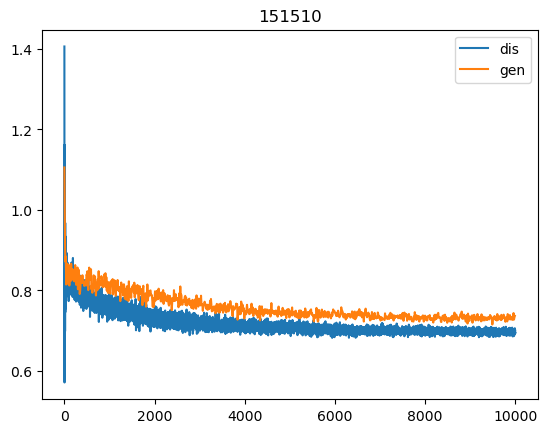

Adversarial training for ST slide 151671: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.86021 dis train loss: 0.853073 dis train accu: 0.289993 
epoch: 1 gen train loss: 0.84787 dis train loss: 0.82498 dis train accu: 0.30289 
epoch: 2 gen train loss: 0.857511 dis train loss: 0.816722 dis train accu: 0.305277 
epoch: 3 gen train loss: 0.843278 dis train loss: 0.811615 dis train accu: 0.309459 
epoch: 4 gen train loss: 0.840075 dis train loss: 0.809655 dis train accu: 0.317999 
epoch: 5 gen train loss: 0.841409 dis train loss: 0.809595 dis train accu: 0.317276 
epoch: 6 gen train loss: 0.849763 dis train loss: 0.804658 dis train accu: 0.320035 
epoch: 7 gen train loss: 0.849471 dis train loss: 0.805821 dis train accu: 0.321612 
epoch: 8 gen train loss: 0.829811 dis train loss: 0.80277 dis train accu: 0.323232 
epoch: 9 gen train loss: 0.858162 dis train loss: 0.803506 dis train accu: 0.328684 
epoch: 10 gen train loss: 0.803842 dis train loss: 0.800515 dis train accu: 0.326122 
epoch: 11 gen train loss: 0.823292 dis train loss: 0.797174 dis train

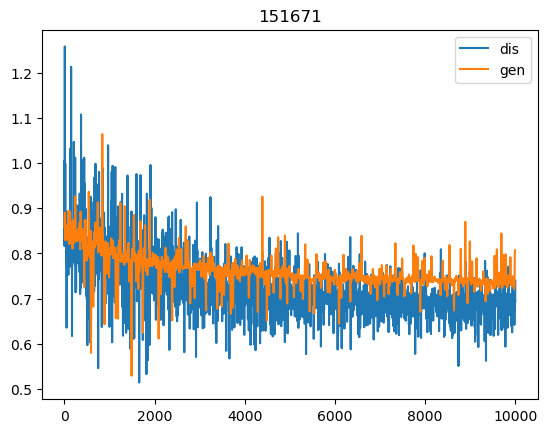

Adversarial training for ST slide 151508: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.86176 dis train loss: 0.856095 dis train accu: 0.28986 
epoch: 1 gen train loss: 0.843595 dis train loss: 0.836054 dis train accu: 0.29898 
epoch: 2 gen train loss: 0.844491 dis train loss: 0.830677 dis train accu: 0.301913 
epoch: 3 gen train loss: 0.852082 dis train loss: 0.825017 dis train accu: 0.304868 
epoch: 4 gen train loss: 0.842694 dis train loss: 0.822795 dis train accu: 0.312181 
epoch: 5 gen train loss: 0.833143 dis train loss: 0.817266 dis train accu: 0.308971 
epoch: 6 gen train loss: 0.838147 dis train loss: 0.809154 dis train accu: 0.311182 
epoch: 7 gen train loss: 0.822897 dis train loss: 0.802664 dis train accu: 0.319685 
epoch: 8 gen train loss: 0.821579 dis train loss: 0.800135 dis train accu: 0.324277 
epoch: 9 gen train loss: 0.826803 dis train loss: 0.798756 dis train accu: 0.322959 
epoch: 10 gen train loss: 0.829403 dis train loss: 0.799611 dis train accu: 0.324787 
epoch: 11 gen train loss: 0.853048 dis train loss: 0.792733 dis tra

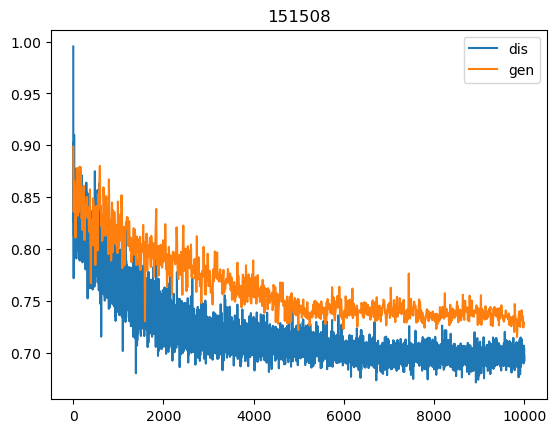

Adversarial training for ST slide 151670: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.811827 dis train loss: 0.845297 dis train accu: 0.281142 
epoch: 1 gen train loss: 0.839715 dis train loss: 0.820029 dis train accu: 0.303388 
epoch: 2 gen train loss: 0.860584 dis train loss: 0.816259 dis train accu: 0.305521 
epoch: 3 gen train loss: 0.845229 dis train loss: 0.813537 dis train accu: 0.309122 
epoch: 4 gen train loss: 0.856897 dis train loss: 0.80526 dis train accu: 0.309789 
epoch: 5 gen train loss: 0.854898 dis train loss: 0.808722 dis train accu: 0.316138 
epoch: 6 gen train loss: 0.843647 dis train loss: 0.809038 dis train accu: 0.316138 
epoch: 7 gen train loss: 0.826707 dis train loss: 0.810443 dis train accu: 0.314671 
epoch: 8 gen train loss: 0.832115 dis train loss: 0.801338 dis train accu: 0.318512 
epoch: 9 gen train loss: 0.824841 dis train loss: 0.795496 dis train accu: 0.323553 
epoch: 10 gen train loss: 0.835046 dis train loss: 0.797367 dis train accu: 0.32366 
epoch: 11 gen train loss: 0.829449 dis train loss: 0.790311 dis tr

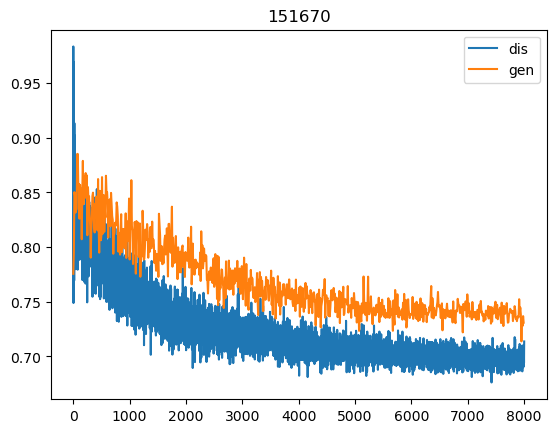

Adversarial training for ST slide 151507: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.842964 dis train loss: 0.844863 dis train accu: 0.2872 
epoch: 1 gen train loss: 0.853035 dis train loss: 0.828632 dis train accu: 0.304757 
epoch: 2 gen train loss: 0.8224 dis train loss: 0.821169 dis train accu: 0.310703 
epoch: 3 gen train loss: 0.835854 dis train loss: 0.811209 dis train accu: 0.314119 
epoch: 4 gen train loss: 0.840027 dis train loss: 0.812267 dis train accu: 0.316605 
epoch: 5 gen train loss: 0.836603 dis train loss: 0.808702 dis train accu: 0.320065 
epoch: 6 gen train loss: 0.822298 dis train loss: 0.806644 dis train accu: 0.317384 
epoch: 7 gen train loss: 0.829366 dis train loss: 0.79842 dis train accu: 0.326119 
epoch: 8 gen train loss: 0.816471 dis train loss: 0.797146 dis train accu: 0.331178 
epoch: 9 gen train loss: 0.822827 dis train loss: 0.78976 dis train accu: 0.330768 
epoch: 10 gen train loss: 0.821322 dis train loss: 0.792895 dis train accu: 0.331827 
epoch: 11 gen train loss: 0.831462 dis train loss: 0.787144 dis train 

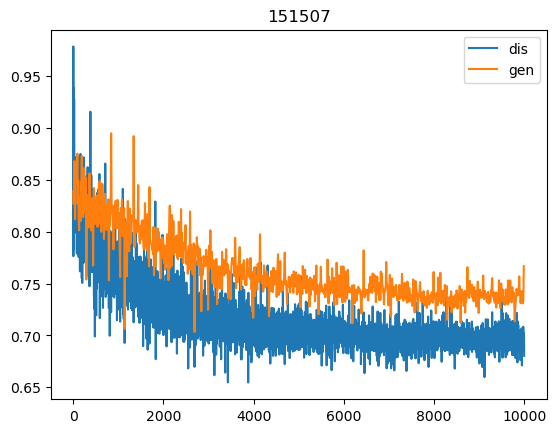

Adversarial training for ST slide 151674: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.838104 dis train loss: 0.84726 dis train accu: 0.28943 
epoch: 1 gen train loss: 0.848721 dis train loss: 0.826437 dis train accu: 0.29652 
epoch: 2 gen train loss: 0.85029 dis train loss: 0.812982 dis train accu: 0.306712 
epoch: 3 gen train loss: 0.851488 dis train loss: 0.815871 dis train accu: 0.305174 
epoch: 4 gen train loss: 0.843849 dis train loss: 0.81221 dis train accu: 0.312707 
epoch: 5 gen train loss: 0.834288 dis train loss: 0.805783 dis train accu: 0.311508 
epoch: 6 gen train loss: 0.825834 dis train loss: 0.800859 dis train accu: 0.315313 
epoch: 7 gen train loss: 0.830849 dis train loss: 0.801102 dis train accu: 0.31461 
epoch: 8 gen train loss: 0.844676 dis train loss: 0.796118 dis train accu: 0.318702 
epoch: 9 gen train loss: 0.838853 dis train loss: 0.794903 dis train accu: 0.323159 
epoch: 10 gen train loss: 0.842198 dis train loss: 0.793952 dis train accu: 0.323837 
epoch: 11 gen train loss: 0.828482 dis train loss: 0.79227 dis train a

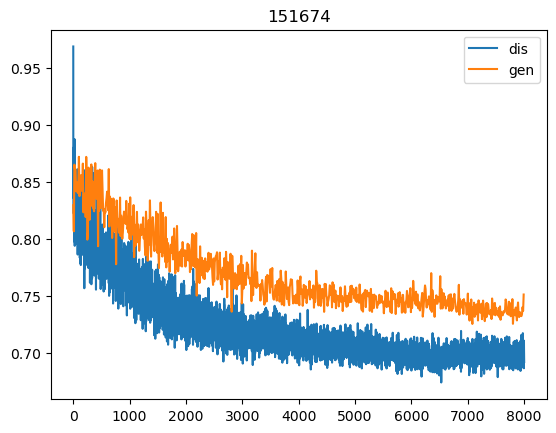

Adversarial training for ST slide 151676: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.932332 dis train loss: 0.86811 dis train accu: 0.296997 
epoch: 1 gen train loss: 0.857269 dis train loss: 0.825402 dis train accu: 0.3037 
epoch: 2 gen train loss: 0.837862 dis train loss: 0.819308 dis train accu: 0.307909 
epoch: 3 gen train loss: 0.856812 dis train loss: 0.821808 dis train accu: 0.30756 
epoch: 4 gen train loss: 0.839927 dis train loss: 0.813976 dis train accu: 0.313887 
epoch: 5 gen train loss: 0.82744 dis train loss: 0.813099 dis train accu: 0.311501 
epoch: 6 gen train loss: 0.821239 dis train loss: 0.807096 dis train accu: 0.314584 
epoch: 7 gen train loss: 0.849554 dis train loss: 0.800092 dis train accu: 0.322493 
epoch: 8 gen train loss: 0.846948 dis train loss: 0.800329 dis train accu: 0.325737 
epoch: 9 gen train loss: 0.837581 dis train loss: 0.793281 dis train accu: 0.328794 
epoch: 10 gen train loss: 0.832703 dis train loss: 0.790858 dis train accu: 0.327828 
epoch: 11 gen train loss: 0.833374 dis train loss: 0.788448 dis train

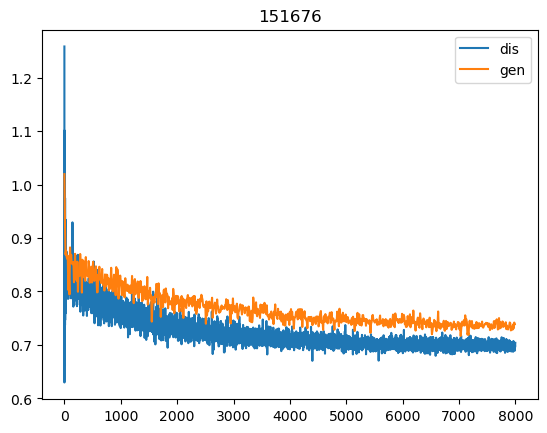

Adversarial training for ST slide 151675: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.727797 dis train loss: 0.850937 dis train accu: 0.25216 
epoch: 1 gen train loss: 0.840193 dis train loss: 0.826954 dis train accu: 0.301317 
epoch: 2 gen train loss: 0.834541 dis train loss: 0.81959 dis train accu: 0.304874 
epoch: 3 gen train loss: 0.836254 dis train loss: 0.816495 dis train accu: 0.305954 
epoch: 4 gen train loss: 0.838678 dis train loss: 0.814293 dis train accu: 0.308535 
epoch: 5 gen train loss: 0.82202 dis train loss: 0.806726 dis train accu: 0.313145 
epoch: 6 gen train loss: 0.840195 dis train loss: 0.8033 dis train accu: 0.319362 
epoch: 7 gen train loss: 0.850303 dis train loss: 0.801522 dis train accu: 0.318862 
epoch: 8 gen train loss: 0.845666 dis train loss: 0.796738 dis train accu: 0.32118 
epoch: 9 gen train loss: 0.841509 dis train loss: 0.798007 dis train accu: 0.320548 
epoch: 10 gen train loss: 0.843581 dis train loss: 0.791551 dis train accu: 0.327002 
epoch: 11 gen train loss: 0.822159 dis train loss: 0.793139 dis train 

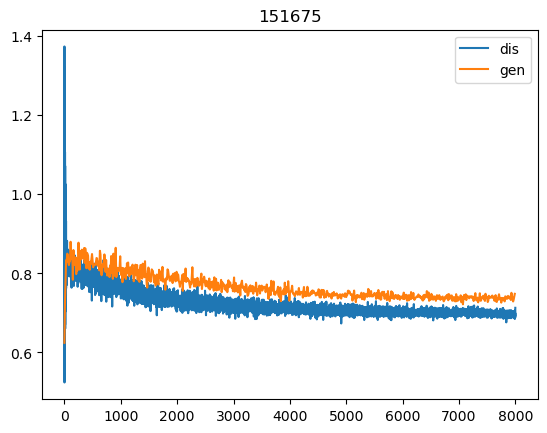

Adversarial training for ST slide 151673: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.860242 dis train loss: 0.854735 dis train accu: 0.285823 
epoch: 1 gen train loss: 0.848613 dis train loss: 0.825131 dis train accu: 0.302867 
epoch: 2 gen train loss: 0.872375 dis train loss: 0.81501 dis train accu: 0.30792 
epoch: 3 gen train loss: 0.830603 dis train loss: 0.808415 dis train accu: 0.308444 
epoch: 4 gen train loss: 0.843616 dis train loss: 0.809701 dis train accu: 0.310145 
epoch: 5 gen train loss: 0.852089 dis train loss: 0.805271 dis train accu: 0.314989 
epoch: 6 gen train loss: 0.841614 dis train loss: 0.802544 dis train accu: 0.316795 
epoch: 7 gen train loss: 0.849001 dis train loss: 0.796063 dis train accu: 0.3158 
epoch: 8 gen train loss: 0.816775 dis train loss: 0.79339 dis train accu: 0.325514 
epoch: 9 gen train loss: 0.825128 dis train loss: 0.792306 dis train accu: 0.325409 
epoch: 10 gen train loss: 0.854133 dis train loss: 0.794756 dis train accu: 0.327713 
epoch: 11 gen train loss: 0.829536 dis train loss: 0.785548 dis train

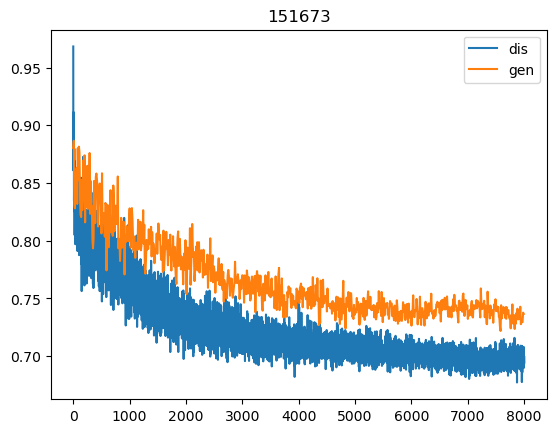

Adversarial training for ST slide 151672: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.810044 dis train loss: 0.842491 dis train accu: 0.274885 
epoch: 1 gen train loss: 0.855701 dis train loss: 0.808561 dis train accu: 0.295371 
epoch: 2 gen train loss: 0.859468 dis train loss: 0.806088 dis train accu: 0.298141 
epoch: 3 gen train loss: 0.857813 dis train loss: 0.811502 dis train accu: 0.304504 
epoch: 4 gen train loss: 0.848489 dis train loss: 0.807445 dis train accu: 0.308522 
epoch: 5 gen train loss: 0.824556 dis train loss: 0.808127 dis train accu: 0.310019 
epoch: 6 gen train loss: 0.842577 dis train loss: 0.807635 dis train accu: 0.309819 
epoch: 7 gen train loss: 0.838573 dis train loss: 0.801116 dis train accu: 0.312364 
epoch: 8 gen train loss: 0.826019 dis train loss: 0.801891 dis train accu: 0.318104 
epoch: 9 gen train loss: 0.83052 dis train loss: 0.79872 dis train accu: 0.321547 
epoch: 10 gen train loss: 0.826584 dis train loss: 0.796192 dis train accu: 0.317804 
epoch: 11 gen train loss: 0.817682 dis train loss: 0.796646 dis tr

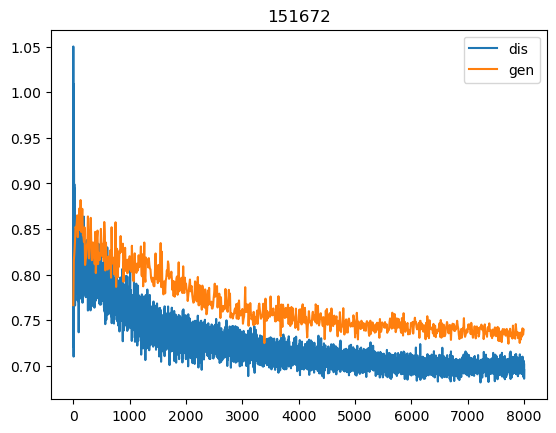

Adversarial training for ST slide 151669: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.720007 dis train loss: 0.856315 dis train accu: 0.241248 
epoch: 1 gen train loss: 0.830003 dis train loss: 0.822296 dis train accu: 0.297011 
epoch: 2 gen train loss: 0.856832 dis train loss: 0.820903 dis train accu: 0.304216 
epoch: 3 gen train loss: 0.84722 dis train loss: 0.808948 dis train accu: 0.30312 
epoch: 4 gen train loss: 0.837702 dis train loss: 0.811982 dis train accu: 0.310717 
epoch: 5 gen train loss: 0.839754 dis train loss: 0.810663 dis train accu: 0.310064 
epoch: 6 gen train loss: 0.817973 dis train loss: 0.808656 dis train accu: 0.31586 
epoch: 7 gen train loss: 0.845137 dis train loss: 0.807182 dis train accu: 0.31706 
epoch: 8 gen train loss: 0.858343 dis train loss: 0.804963 dis train accu: 0.319984 
epoch: 9 gen train loss: 0.835022 dis train loss: 0.804203 dis train accu: 0.319514 
epoch: 10 gen train loss: 0.824956 dis train loss: 0.796437 dis train accu: 0.320402 
epoch: 11 gen train loss: 0.815891 dis train loss: 0.793577 dis trai

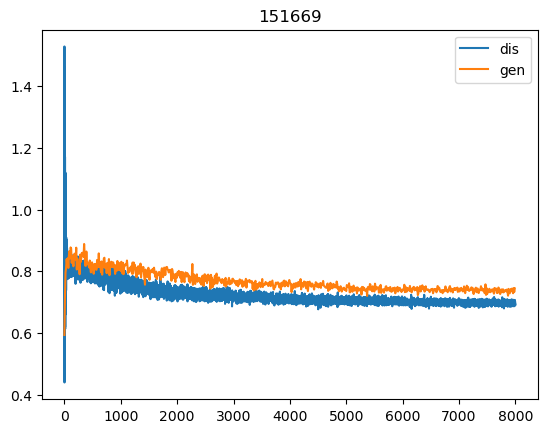

In [22]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model = ADDAST(
        sc_mix_train_s.shape[1],
        emb_dim=64,
        ncls_source=lab_mix_train.shape[1],
        is_adda=True,
    )

    model.init_adv()
    model.apply(initialize_weights)
    model.source_encoder.load_state_dict(
        best_checkpoint["model"].source_encoder.state_dict()
    )
    model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
        dataloader_target_train_dis,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

        model = ADDAST(
            sc_mix_train_s.shape[1],
            emb_dim=64,
            ncls_source=lab_mix_train.shape[1],
            is_adda=True,
        )
        model.init_adv()
        model.apply(initialize_weights)
        
        model.source_encoder.load_state_dict(
            best_checkpoint["model"].source_encoder.state_dict()
        )
        model.target_encoder.load_state_dict(
            best_checkpoint["model"].source_encoder.state_dict()
        )
        model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())
        model.to(device)

        model.advtraining()

        loss_history_running, loss_history_gen_running = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
            dataloader_target_train_dis_d[sample_id],
        )
        loss_history_gen_running = np.ravel(loss_history_gen_running)
        x = np.arange(0, len(loss_history_gen_running)*(DIS_LOOP_FACTOR*2), DIS_LOOP_FACTOR*2)

        plt.plot(np.ravel(loss_history_running), label="dis")
        plt.plot(x, loss_history_gen_running, label="gen")
        plt.legend()
        plt.title(sample_id)
        plt.show()


## Evaluation of latent space

In [23]:
# from sklearn.decomposition import PCA
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier


# for sample_id in st_sample_id_l:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#     )
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()

#     with torch.no_grad():
#         source_emb = model.source_encoder(torch.Tensor(sc_mix_train_s).to(device))
#         target_emb = model.target_encoder(
#             torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
#         )

#         y_dis = torch.cat(
#             [
#                 torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
#                 torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
#             ]
#         )

#         emb = torch.cat([source_emb, target_emb])

#         emb = emb.detach().cpu().numpy()
#         y_dis = y_dis.detach().cpu().numpy()

#     (emb_train, emb_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
#         emb,
#         y_dis,
#         test_size=0.2,
#         random_state=225,
#         stratify=y_dis,
#     )

#     pca = PCA(n_components=50)
#     pca.fit(emb_train)

#     emb_train_50 = pca.transform(emb_train)
#     emb_test_50 = pca.transform(emb_test)

#     clf = RandomForestClassifier(random_state=145, n_jobs=-1)
#     clf.fit(emb_train_50, y_dis_train)
#     accu_train = clf.score(emb_train_50, y_dis_train)
#     accu_test = clf.score(emb_test_50, y_dis_test)
#     class_proportions = np.mean(y_dis)

#     print(
#         "Training accuracy: {}, Test accuracy: {}, Class proportions: {}".format(
#             accu_train, accu_test, class_proportions
#         )
#     )


 # 4. Predict cell fraction of spots and visualization

In [24]:
# pred_sp_d, pred_sp_noda_d = {}, {}
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()
#     with torch.no_grad():
#         for sample_id in st_sample_id_l:
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )

# else:
#     for sample_id in st_sample_id_l:
#         best_checkpoint = torch.load(
#             os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#         )
#         model = best_checkpoint["model"]
#         model.to(device)

#         model.eval()
#         model.target_inference()

#         with torch.no_grad():
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )


# best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     for sample_id in st_sample_id_l:
#         pred_sp_noda_d[sample_id] = (
#             torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
#             .detach()
#             .cpu()
#             .numpy()
#         )


In [25]:
# adata_spatialLIBD = sc.read_h5ad(
#     os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
# )

# adata_spatialLIBD_d = {}
# for sample_id in st_sample_id_l:
#     adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ]
#     adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
#         adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
#     )


In [26]:
# num_name_exN_l = []
# for k, v in sc_sub_dict.items():
#     if "Ex" in v:
#         num_name_exN_l.append((k, v, int(v.split("_")[1])))
# num_name_exN_l.sort(key=lambda a: a[2])
# num_name_exN_l


In [27]:
# Ex_to_L_d = {
#     1: {5, 6},
#     2: {5},
#     3: {4, 5},
#     4: {6},
#     5: {5},
#     6: {4, 5, 6},
#     7: {4, 5, 6},
#     8: {5, 6},
#     9: {5, 6},
#     10: {2, 3, 4},
# }


In [28]:
# numlist = [t[0] for t in num_name_exN_l]
# Ex_l = [t[2] for t in num_name_exN_l]
# num_to_ex_d = dict(zip(numlist, Ex_l))


In [29]:
# def plot_cellfraction(visnum, adata, pred_sp, ax=None):
#     """Plot predicted cell fraction for a given visnum"""
#     adata.obs["Pred_label"] = pred_sp[:, visnum]
#     # vmin = 0
#     # vmax = np.amax(pred_sp)

#     sc.pl.spatial(
#         adata,
#         img_key="hires",
#         color="Pred_label",
#         palette="Set1",
#         size=1.5,
#         legend_loc=None,
#         title=f"{sc_sub_dict[visnum]}",
#         spot_size=100,
#         show=False,
#         # vmin=vmin,
#         # vmax=vmax,
#         ax=ax,
#     )


In [30]:
# def plot_roc(visnum, adata, pred_sp, name, ax=None):
#     """Plot ROC for a given visnum"""

#     def layer_to_layer_number(x):
#         for char in x:
#             if char.isdigit():
#                 if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
#                     return 1
#         return 0

#     y_pred = pred_sp[:, visnum]
#     y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
#     # print(y_true)
#     # print(y_true.isna().sum())
#     RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


In [31]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

# sc.pl.spatial(
#     adata_spatialLIBD_d[SAMPLE_ID_N],
#     img_key=None,
#     color="spatialLIBD",
#     palette="Accent_r",
#     size=1.5,
#     title=SAMPLE_ID_N,
#     # legend_loc = 4,
#     spot_size=100,
#     show=False,
#     ax=ax,
# )

# ax.axis("equal")
# ax.set_xlabel("")
# ax.set_ylabel("")

# fig.show()


In [32]:
# fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

# for i, num in enumerate(numlist):
#     plot_cellfraction(
#         num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
#     )
#     ax.flat[i].axis("equal")
#     ax.flat[i].set_xlabel("")
#     ax.flat[i].set_ylabel("")

# fig.show()

# fig, ax = plt.subplots(
#     2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
# )

# for i, num in enumerate(numlist):
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_d[SAMPLE_ID_N],
#         "ADDA",
#         ax.flat[i],
#     )
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_noda_d[SAMPLE_ID_N],
#         "NN_wo_da",
#         ax.flat[i],
#     )
#     ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     ax.flat[i].set_title(f"{sc_sub_dict[num]}")

#     if i >= len(numlist) - 5:
#         ax.flat[i].set_xlabel("FPR")
#     else:
#         ax.flat[i].set_xlabel("")
#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("TPR")
#     else:
#         ax.flat[i].set_ylabel("")

# fig.show()


In [33]:
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
# else:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
#     )

# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     pred_mix = (
#         torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
#         .detach()
#         .cpu()
#         .numpy()
#     )

# cell_type_nums = sc_sub_dict.keys()
# nrows = ceil(len(cell_type_nums) / 5)

# line_kws = {"color": "tab:orange"}
# scatter_kws = {"s": 5}

# props = dict(facecolor="w", alpha=0.5)

# fig, ax = plt.subplots(
#     nrows,
#     5,
#     figsize=(25, 5 * nrows),
#     constrained_layout=True,
#     sharex=False,
#     sharey=True,
# )
# for i, visnum in enumerate(cell_type_nums):
#     sns.regplot(
#         x=pred_mix[:, visnum],
#         y=lab_mix_test[:, visnum],
#         line_kws=line_kws,
#         scatter_kws=scatter_kws,
#         ax=ax.flat[i],
#     ).set_title(sc_sub_dict[visnum])

#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlabel("Predicted Proportion")

#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("True Proportion")
#     else:
#         ax.flat[i].set_ylabel("")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     textstr = (
#         f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
#     )

#     # place a text box in upper left in axes coords
#     ax.flat[i].text(
#         0.95,
#         0.05,
#         textstr,
#         transform=ax.flat[i].transAxes,
#         verticalalignment="bottom",
#         horizontalalignment="right",
#         bbox=props,
#     )

# for i in range(len(cell_type_nums), nrows * 5):
#     ax.flat[i].axis("off")

# plt.show()
